# A Big Dam Problem: Understanding the Potential Impacts of Future Dam Development 
Contributors: Steph Shepherd & Lauren Herwehe

## We should give a dam

Dam construction over the past century has dramatically altered our landscapes, threatening ecosystems and endangered species around the world. Thousands of new dams are proposed globally that would affect protected areas such as National Parks, UNESCO World Heritage Sites, and Ramsar Sites. While data is publicly available, there is scant understanding of how these proposed dams will affect these critical protected areas.

Many scientists believe we may be on the cusp of the sixth Mass Extinction in Earth’s history, due to human impact on the environment (1). Since the early 20th Century the majority of major rivers around the globe have been impounded or diverted to harness the power of water for energy production, transportation, flood control, water storage, and even recreation (2, 3).  Although we as a society benefit greatly from the construction of these engineering marvels, dams have a dramatic impact on river ecosystems. A dam drastically slows water flow, trapping sediment, fish, and water upstream as the reservoir fills flooding the river valley. As a result both the river habitats and the riparian habitats are lost. Downstream of the dam water flow is strictly controlled, often eliminating the natural annual cycles of flooding that supplied sediment and nutrients to the floodplain. When water flow exceeds the storage capacity of the dam, the water released often causes catastrophic flooding downstream. Even as the water rushes out the necessary sediment, nutrients, and organisms are for the most part still trapped behind the dam. Finally dam construction alters the aesthetics of beautiful landscapes around the world and threatening freshwater and terrestrial species (4).

This project is being undertaken in collaboration with the World Wildlife Foundation for the purpose of identifying critical habitats that will potentially be impacted by future dam construction. 


## What do we already know
Global Dam Watch (http://globaldamwatch.org/) is a collaboration between academic institutions and non-governmental organizations to collect, analyze, and curate data about current and future dams around the globe. The collaboration maintains three dam databases:
* GlObal geOreferenced Database of Dams (GOODD) - http://globaldamwatch.org/goodd/
* Global Reservoir and Dam Database (GRand) - http://globaldamwatch.org/grand/
* Future Hydropower Reservoirs and Dams (FHReD) - http://globaldamwatch.org/fhred/

These datasets have already contributed to our understanding of how current dam infrastructure effects the movement and storage of water and sediment(5, 6), the impacts on riparian wetlands(7), as well as the preservation and restoration of free-flowing rivers (8). 

## Exploring the data

These databases paint a clear picture of the distribution of dams globally which allows us now to assess their impacts in different ways.  For the larger project we will identify protected areas that will potentially be impacted from the development of new dams around the globe.  For this preliminary work we are using the FHReD datase,  which contains geographic information about dams such as main river dammed and country as well as dam capacity, project name, and development stage, and the Ramsar Site database (https://rsis.ramsar.org/), which list wetland areas of critical importance as identified under the Convention on Wetlands (1971).  

## Import packages, define functions, and acquire data

In [1]:
# Imports
import os
import sys

import numpy as np
import numpy.ma as ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import geopandas as gpd
from geopandas import GeoDataFrame as gdf
from geopandas import GeoSeries as gs
from shapely.geometry import Point, Polygon

import contextily as ctx
import earthpy as et
import earthpy.plot as ep

In [2]:
# Check path and set working directory.
wd_path = os.path.join(et.io.HOME, 'earth-analytics', 'data')
if os.path.exists(wd_path):
    os.chdir(wd_path)
else:
    print("Path does not exist")

In [3]:
# Custon Function 1
def dam_impact(buff_km, country):
    """ This function takes a country name, pulls the proposed 
    dams & ramsar areas for the country, creates a 5km & 10km 
    buffer around the dams, and returns the total ramsar area covered
    by each buffer.

    Parameters
    ----------
    buff_km: int or float
        The number of kilometers buffer you want around the dam.
    country: str
        Full name of the country to be analyzed in quotes.

    Returns
    -------
    ramsar_affected: float
        Total ramsar area affected in the country by proposed dams with buffer.
    """
    # Pull only the data for the country
    proposed_dams_cntry = proposed_dams[proposed_dams['Country'] == country]
    ramsar_areas_cntry = ramsar_areas[ramsar_areas['country_en'] == country]

    # Buffer the dams to 5km & 10km to create gdfs of only the intersections
    proposed_dams_cntry['geometry'] = proposed_dams_cntry.buffer(
        buff_km * 1000)
    try:
        data_intersect_cntry = gpd.overlay(
            ramsar_areas_cntry, proposed_dams_cntry, how='intersection')
        # divide by 1 million because it sq km
        ramsar_affected = ((data_intersect_cntry.area.sum())/1000000).round(1)
        return ramsar_affected
    except IndexError as err:
        Dams = None

In [4]:
# Custom Function 2
def autolabel(rects): # width, dataframe, width, label are other
    """Attach a text label above each bar in *rects*, displaying its value.
    
    Parameters
    ----------
    rect: list 
        The list of values or count of items for the category.
    
    Returns
    -------
    label: int
        The value or count of items in a category.
    """
    
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [5]:
# Custom function 3
# This function isn't used in this notebook but will be useful for future analysis
def ramsar_area(country):
    """ This function takes a country name and pulls the total area of Ramsar Designated sites for it.

    Parameters
    ----------
    country: str
        Full name of the country to be analyzed in quotes (e.g. 'Mexico').

    Returns
    -------
    total_ramsar: float
        Total area of Ramsar sites in the country.

    """
    # Pull only the data for the country & calculate total area
    ramsar_areas_cntry = ramsar_areas[ramsar_areas['country_en'] == country]
    total_ramsar = ((ramsar_areas_cntry.area.sum())/1000000).round(1)

    return total_ramsar

In [6]:
# Download Data stored on figshare
# Ramsar Sites
et.data.get_data(url="https://ndownloader.figshare.com/files/22507082")

# Future dams
et.data.get_data(url="https://ndownloader.figshare.com/files/22486157")

# Country boundaries
et.data.get_data(url="https://ndownloader.figshare.com/files/22507058")

'C:\\Users\\lherwehe\\earth-analytics\\data\\earthpy-downloads\\country-borders'

In [8]:
# Open the ramsar shapefile with geopandas
ramsar_all = gpd.read_file(os.path.join(
    "earthpy-downloads", "ramsar-site-data", "ramsar-boundaries",
    "features_publishedPolygon.shp"))

# Check the crs of the ramsar sites
print(ramsar_all.crs)

# Open the dams csv files with pandas
fname = os.path.join("earthpy-downloads", "future_dams_2015.csv")
df = pd.read_csv(fname)

# Covert the pandas dataframe to a shapefile for plotting
# Set output path for shp
dams_path = os.path.join('earthpy-downloads')
if not os.path.exists(dams_path):
    os.mkdir(dams_path)

# Define the geometry for the points
geometry = [Point(xy) for xy in zip(df.Lon_Cleaned, df.LAT_cleaned)]
crs = {'init': 'epsg:4326'}
geo_df = gdf(df, crs=crs, geometry=geometry)
geo_df.to_file(driver='ESRI Shapefile', filename=os.path.join(
    dams_path, 'proposed_dams.shp'))

# Open the proposed dams shapefile with geopandas
dams_all = gpd.read_file(os.path.join(dams_path, "proposed_dams.shp"))

# Pull only the columns that we need from each gdf to save processing time
proposed_dams = dams_all[['Country',
                               'Continent', 'Major Basi', 'Stage', 'geometry']]
ramsar_areas = ramsar_all[['country_en', 'geometry']]

# Open country borders shapefile for adding boundary of study area
country_borders_path = os.path.join("earthpy-downloads", "country-borders",
                                    "99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp")
country_borders = gpd.read_file(country_borders_path)

{'init': 'epsg:4326'}


# Global Map of Future Dams and Ramsar Sites

In order to visual the scope of the two databases selected for this project, we initially plotted the entire FHReD database with the Ramsar site polygons.  At a global scale we can see the proposed dams are concentrated in Africa, Asia, and South America, but the Ramsar sites just fade into the background.  

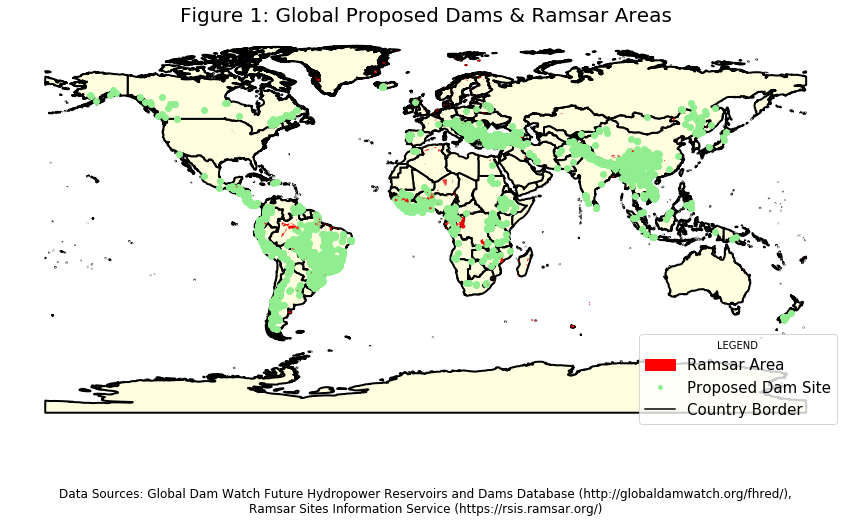

In [9]:
# Create a Global Map of Dams and Ramsar Sites
red_patch = mpatches.Patch(color='red', label='Ramsar Area')
green_dot = mlines.Line2D([], [], color='white', marker='o',
                          markerfacecolor='lightgreen', label='Proposed Dam Site')
black_line = mlines.Line2D([], [], color='black', label='Country Border')

fig, ax = plt.subplots(figsize=(15, 25))
country_borders.plot(ax=ax, color="lightyellow",
                     edgecolor="black", linewidth=2)
proposed_dams.plot(ax=ax,
#                   markersize=15,
                   color='lightgreen', legend=True)
ramsar_areas.plot(ax=ax, facecolor='red', legend=True)
ax.set_title(
    'Figure 1: Global Proposed Dams & Ramsar Areas', size=20)
ax.set_axis_off()
ax.text(0.5, -0.2, "Data Sources: Global Dam Watch Future Hydropower Reservoirs "
        "and Dams Database (http://globaldamwatch.org/fhred/),\nRamsar Sites "
        "Information Service (https://rsis.ramsar.org/)",
        size=12, ha="center", transform=ax.transAxes)
ax.legend(handles=[red_patch, green_dot, black_line],
          fontsize=15,
          frameon=True,
          loc=('lower right'),
          title="LEGEND")

# Future Dam Construction by Continent and Selected Countries




## Visualizing the data at the continent scale
Stepping down to the continent scale, we compared the number of dams underconstruction (U) and planned (P).  

In [ ]:
# Getting Number of Dams by Continent and Development State
# Extact the columns needed for analysis
dams_continent = dams_all[['Continent', 'Country', 'Stage']]

# Group and count data by stage.
dams_stage = dams_continent.groupby(['Continent', 'Country', 'Stage'])[
    ['Stage']].count()

dams_stage

In [ ]:
# PLOT - NUMBER OF DAMS PROPOSED VS UNDER CONSTRUCTION BY CONTINENT
# Create a bar plot of the dams by continent and stage of process.
labels = ['Africa', 'Asia', 'Europe', 'N. America', 'Oceania', 'S. America']
proposed = [179, 937, 611, 143, 7, 1188]
under_const = [21, 424, 41, 34, 1, 114]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(x - width/2, proposed, width, label='Proposed')
rects2 = ax.bar(x + width/2, under_const, width, label='Under Construction')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count', size=15)
ax.set_title('Figure 2: Future Dams by Continent, 2015', size=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, size=15, rotation=45)
ax.legend()

autolabel(rects1)
autolabel(rects2)

ax.text(0.5, -0.2, "Data Source: Global Dam Watch Future Hydropower "
        "Reservoirs and Dams Database (http://globaldamwatch.org/fhred/)",
        size=12, ha="center", transform=ax.transAxes)
fig.tight_layout()

plt.show()

## Visualizing the data at the country scale
Again, stepping down to the country scale, we compared future dam construction by stage.  For this projet we are focusing on Africa as a test case for future analysis with other protected area datasets.  

In [ ]:
# Extract data by continent.
africa = dams_continent[dams_continent["Continent"] == "Africa"]

# Group and count country data by stage.
africa_stage = africa.groupby(['Country', 'Stage'])[['Stage']].count()

africa_stage

In [ ]:
# Create a bar plot of the dams by countries in Africa comparing stage of process.
africa_labels = ['Benin', 'Burkina Faso', 'Gabon', 'Guinea', 'Malawi', 'Mali', 'Morocco',
                 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'South Africa', 'Zimbabwe']
africa_proposed = [6, 2, 1, 23, 2, 12, 0, 3, 3, 1, 1, 0, 3, 2]
africa_under_const = [0, 0, 1, 0, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1]

x = np.arange(len(africa_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(x - width/2, africa_proposed, width, label='Proposed')
rects2 = ax.bar(x + width/2, africa_under_const,
                width, label='Under Construction')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count', size=15)
ax.set_title(
    'Figure 3: Future Dam Construction by Selected Countries in Africa', size=20)
ax.set_xticks(x)
ax.set_xticklabels(africa_labels, size=15, rotation=45)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its value."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

ax.text(0.5, -0.2, "Data Source: Global Dam Watch Future Hydropower Reservoirs "
        "and Dams Database (http://globaldamwatch.org/fhred/)",
        size=12, ha="center", transform=ax.transAxes)

fig.tight_layout()

plt.show()

# Overlaying Future Dams and Ramsar Sites in Africa.
In order to analyze these datasets for one continent we had to choose a coordinate reference system that would minimize spatial distortion in the dataset.  Also, we had to check that the country names matched for both datasets (they did not).  Once those issues were addressed, the buffer function was run and the results were saved to Pandas dataframe for plotting.  An important caveat to the results generated from these data is we have not accounted for the flow direction of the river.  We will incorporate this information in the future to further refine our buffer function.

In [ ]:
# Change the datas CRS to projected for Africa (WGS 84 World Mercator)
# To make this data more accurate, for the next course we can create 
# list of EPSG for each country in Africa to include in function
proposed_dams = proposed_dams.to_crs('epsg:3765')
ramsar_areas = ramsar_areas.to_crs('epsg:3765')

In [ ]:
# Get dam impact by African country
# List of African country names
# Data cleaning issues: Removed 'Côte d'Ivoire' bc in Ramsar dataset it's called Cite D'ivore and don't know how to deal with additional ' in a string; also removed Congo bc in Ramsar it's called Congo & Democratic Republic of Congo and in FhRED it's called Congo, Rep.
africa_cntry = ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
                'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic',
                'Chad', 'Comoros', 'Djibouti', 'Equatorial Guinea', 'Eritrea',
                'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
                'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 
                'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 
                'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 
                'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan',
                'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe']

# Empty Africa dict
africa_dams = {}

# Append dam_impact function data to africa_dams
for i in africa_cntry:
    try:
        africa_dams[i] = {"5km Buffer Area": dam_impact(
            5, i), "10km Buffer Area": dam_impact(10, i)}
    except:
        dams = None
        
# Turn it into a pandas dataframe for plotting
africa_df = pd.DataFrame.from_dict(africa_dams)

# Some values in the dataframe are zero and some are NaN, make it the same
africa_df = africa_df.fillna('None')
africa_df.replace({0: 'None'})

In [ ]:
# Plot data to illustrate which countires have potential imapcts from proposed dams.
# Create legend so only countries with potential impacts are listed.
blue_patch = mpatches.Patch(color='dodgerblue', label='Benin')
green_patch = mpatches.Patch(color='green', label='Gabon')
red_patch = mpatches.Patch(color='red', label='Guinea')
teal_patch = mpatches.Patch(color='c', label='Niger')

# Create the figure
fig, ax = plt.subplots(figsize=(8, 8))
africa_df.plot(ax=ax, kind='barh', stacked=True, legend=True)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Affected Area (km)', size=15)
ax.set_title(
    'Figure 4: Total Area of Ramsar Sites in Africa\nPotentially Impacted by Dam Construction', size=20)
ax.text(0.5, -0.2, "Data Sources: Global Dam Watch Future Hydropower Reservoirs "
        "and Dams Database (http://globaldamwatch.org/fhred/),\nRamsar Sites "
        "Information Service (https://rsis.ramsar.org/)",
        size=12, ha="center", transform=ax.transAxes)
ax.legend(handles=[blue_patch, green_patch, red_patch, teal_patch],
          fontsize=15,
          frameon=True,
          loc=('lower right'),
          title="Country")

# Mapped Buffer Results for Guinea

In [ ]:
# Analyze Guinea
# Pull only the data for Guinea
proposed_dams_guin = proposed_dams[proposed_dams['Country'] == "Guinea"]
ramsar_areas_guin = ramsar_areas[ramsar_areas['country_en'] == "Guinea"]
guinea_border = country_borders[country_borders['CNTRY_NAME'] == "Guinea"]

# Get the CRS right for plotting
proposed_dams_guin = proposed_dams_guin.to_crs('epsg:3462')
ramsar_areas_guin = ramsar_areas_guin.to_crs('epsg:3462')
guinea_border = guinea_border.to_crs('epsg:3462')

# Buffer the dams to 5km & 10km for plotting
proposed_dams_guin_5k_buff = proposed_dams_guin.buffer(5000)
proposed_dams_guin_10k_buff = proposed_dams_guin.buffer(10000)

In [ ]:
# Create a map of the dams and the ramsar sites for Guinea
black_line = mlines.Line2D([], [], color='black', label='Country Border')
yellow_patch = mpatches.Patch(color='yellow', label='Ramsar Area')
green_circle = mlines.Line2D([], [], color='white', marker='o',
                             markerfacecolor='forestgreen', markersize=18, 
                             label='10km Buffer')
lime_circle = mlines.Line2D([], [], color='white', marker='o',
                            markerfacecolor='lime', markersize=12, 
                            label='5km Buffer')
red_dot = mlines.Line2D([], [], color='white', marker='o',
                        markerfacecolor='red', label='Proposed Dam Site')

fig, ax = plt.subplots(figsize=(15, 15))
ramsar_areas_guin.plot(ax=ax, facecolor='yellow')
proposed_dams_guin_10k_buff.plot(facecolor='forestgreen',
                                 ax=ax)
proposed_dams_guin_5k_buff.plot(facecolor='lime',
                                ax=ax)
proposed_dams_guin.plot(ax=ax,
                        markersize=5,
                        color='red')
guinea_border.plot(ax=ax, color="none",  edgecolor="black", linewidth=2)
ax.legend(handles=[black_line, yellow_patch, green_circle, lime_circle, red_dot],
          fontsize=15,
          frameon=True,
          loc=('upper right'),
          title="LEGEND")
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=0)
ax.set_axis_off()
ax.set_title(
    'Figure 5: Guinea Ramsar Areas, Proposed Dams, and Dam Buffer Areas', size=20)
ax.text(0.5, -0.1, "Data Sources: Global Dam Watch Future Hydropower Reservoirs "
        "and Dams Database (http://globaldamwatch.org/fhred/), \n Ramsar Sites "
        "Information Service (https://rsis.ramsar.org/)",
        size=12, ha="center", transform=ax.transAxes)

# Conclusions
These two data sets provide a window into protected areas that are threatened by new dam construction country by country, providing the basic code we can use to expand our analysis. Although there are high numbers of dams that are under construction or planned globally---particularly in Africa, Asia, Europe, and South America---there are not wetlands sites within a 5 km and 10 km buffer zone of these dams in most countries. To fully understand the potential impacts we need to include other designated protected areas. We also need to create a more versatile buffer that is different size upstream and downstream of the dam site and possibly rectangular to accommodate the natural geometry of a river valley.  

## Next Steps
It is fortunate that we have an entire additional course to explore the question of how dams affect protected areas both in the past, present, and future. Using the current datasets, with more time, we can expand the study area to other continents. We will also take into account flow direction (upstream vs. downstream), the proposed reservoir capacity. We will also expand the protected areas considered to include National Parks, World Heritage Sites, and similar.  

There are other datasets available for analysis as we expand this work. For example, the World Database of Protected Areas (WDPA), published by the UN Environment, has information on all protected areas around the world. We chose not to use the WDPA data for this project because it will require some cleaning prior to analysis. 


# References
1. Kolbert, E. 2014. The Sixth Extinction. New York: Henry Holt and Company. 320 p.
2. Graf, W.L. 2001. Damage Control: Restoring the Physical Integrity of America’s Rivers in The Annals of the Association of American Geographers, 91(1), p. 1-27.
3. Nilsson, C., Reidy, C.A., Dynesius, M., Revenga, C.. 2014. Fragmentation and Flow Regulation of the World’s Large River Systems in Science, 308(5720), p. 405-408. DOI: 10.1126/science.1107887
4. McAllister, D.E., Craig, J.F., Davidson, N., Delany, S., Seddon, M. 2001. Biodiversity Impacts of Large Dams. International Union for Conservation of Nature and Natural Resource and the United Nations Environmental Programme Report. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.392.9398&rep=rep1&type=pdf
5. Zhou, T., Nijssen, B. 2016. The contribution of reservoirs to global land surface water storage variations in Journal of Hydrometeorology. 17(1), p. 309-325. https://journals.ametsoc.org/doi/full/10.1175/JHM-D-15-0002.1
6. Tessler, Z.D., Vorosmarty, C.J., Overeem, I., Syvitski, J.P.M. 2018. A model of water and sediment balance as determinants of relative sea level rise in contemporary and future deltas. in Geomorphology. 305, p. 209-220.
7. Schneider, C., Florke, M., De Stefano, L., Petersen-Perlman, J.D. 2017. Hydrological threats to riparian wetlands of international importance - a global quantitative and qualitative analysis. in Hydrologic Earth Systems Science. 21, p. 2799-2815.
8. Grill, G. et al. 2019. Mapping the world's free-flowing rivers. in Nature.569(7755), p. 215-221. https://www.researchgate.net/publication/332961728_Mapping_the_world's_free-flowing_rivers#fullTextFileContent